In [1]:
import os
import sys
from collections import Counter

import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchinfo
import torchvision
from PIL import Image
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from tqdm.version import __version__ as tqdm__version__

torch.backends.cudnn.deterministic = True

In [2]:
print("Platform:", sys.platform)
print("Python version:", sys.version)
print("---")
print("CV2 version : ", cv2.__version__)
print("matplotlib version : ", matplotlib.__version__)
print("numpy version : ", np.__version__)
print("torch version : ", torch.__version__)
print("torchinfo version : ", torchinfo.__version__)
print("torchvision version : ", torchvision.__version__)
print("PIL version : ", PIL.__version__)
print("scikit-learn version: ", sklearn.__version__)
print("tqdm version: ", tqdm__version__)

Platform: linux
Python version: 3.11.0 (main, Nov 15 2022, 20:12:54) [GCC 10.2.1 20210110]
---
CV2 version :  4.10.0
matplotlib version :  3.9.2
numpy version :  1.26.3
torch version :  2.2.2+cu121
torchinfo version :  1.8.0
torchvision version :  0.17.2+cu121
PIL version :  10.2.0
scikit-learn version:  1.5.2
tqdm version:  4.66.5


In [3]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cuda device.


In [4]:
data_dir = os.path.join("data_p1", "data_binary")
train_dir = os.path.join(data_dir, "train")
print(data_dir)
print(train_dir)

data_p1/data_binary
data_p1/data_binary/train


In [5]:
labels= os.listdir(train_dir)
labels

['hog', 'blank']

In [6]:
hog_path = os.path.join(train_dir, "hog")
hog_path

'data_p1/data_binary/train/hog'

In [7]:
blank_path = os.path.join(train_dir, "blank")
blank_path

'data_p1/data_binary/train/blank'

In [8]:
# hog_image_path = os.path.join(hog_path, "ZJ0000032.jpg")
# print(hog_image_path)
# hog_image_pil = Image.open(hog_image_path)

In [9]:
hog_image = os.listdir(hog_path) [0]
hog_image
hog_image_path = os.path.join(hog_path, hog_image)
hog_image_pil = Image.open(hog_image_path)

In [10]:
hog_image_pil.mode
hog_image_pil.size

(360, 240)

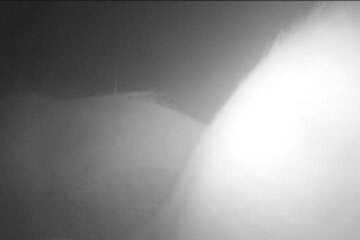

In [11]:
hog_image_pil

Text(0.5, 1.0, 'hog_image')

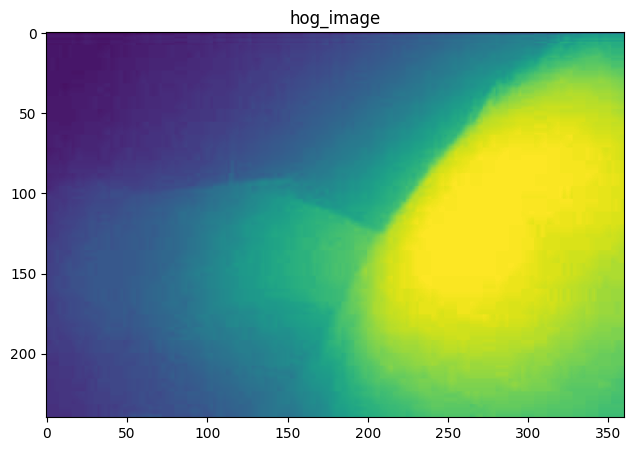

In [12]:
fig, ax = plt.subplots(figsize=(10,5))
ax.imshow(hog_image_pil)
ax.set_title("hog_image")


In [13]:
class ConvertToRGB:
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img
    

In [14]:
transform = transforms.Compose(
    [ConvertToRGB(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()]
)
print(type(transform))
print(transform)

<class 'torchvision.transforms.transforms.Compose'>
Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [15]:
dataset = datasets.ImageFolder(root=train_dir, transform=transform)

In [16]:
dataset.classes

['blank', 'hog']

In [17]:
dataset.imgs

[('data_p1/data_binary/train/blank/ZJ000013.jpg', 0),
 ('data_p1/data_binary/train/blank/ZJ000015.jpg', 0),
 ('data_p1/data_binary/train/blank/ZJ000018.jpg', 0),
 ('data_p1/data_binary/train/blank/ZJ000029.jpg', 0),
 ('data_p1/data_binary/train/blank/ZJ000041.jpg', 0),
 ('data_p1/data_binary/train/blank/ZJ000045.jpg', 0),
 ('data_p1/data_binary/train/blank/ZJ000051.jpg', 0),
 ('data_p1/data_binary/train/blank/ZJ000061.jpg', 0),
 ('data_p1/data_binary/train/blank/ZJ000062.jpg', 0),
 ('data_p1/data_binary/train/blank/ZJ000064.jpg', 0),
 ('data_p1/data_binary/train/blank/ZJ000070.jpg', 0),
 ('data_p1/data_binary/train/blank/ZJ000082.jpg', 0),
 ('data_p1/data_binary/train/blank/ZJ000084.jpg', 0),
 ('data_p1/data_binary/train/blank/ZJ000091.jpg', 0),
 ('data_p1/data_binary/train/blank/ZJ000100.jpg', 0),
 ('data_p1/data_binary/train/blank/ZJ000104.jpg', 0),
 ('data_p1/data_binary/train/blank/ZJ000107.jpg', 0),
 ('data_p1/data_binary/train/blank/ZJ000110.jpg', 0),
 ('data_p1/data_binary/train

In [18]:
img = dataset.imgs

distinct_classes = {x[1] for x in dataset.imgs}
distinct_classes

{0, 1}

In [19]:
g = torch.Generator()
g.manual_seed(42)
train_dataset, val_dataset = random_split(dataset, [0.8,0.2], generator=g)

In [20]:
print(len(train_dataset))
print(len(val_dataset))

2553
638


In [21]:
# Important, don't change this!
g = torch.Generator()
g.manual_seed(42)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=g)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, generator=g)

print(type(val_loader))

<class 'torch.utils.data.dataloader.DataLoader'>


In [22]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

In [23]:
images.dtype

torch.float32

In [24]:
flatten = nn.Flatten()
tensor_flatten = flatten(images)

In [25]:
# Image size from our transformer
height = 224
width = 224

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3 * height * width, 512),
    nn.ReLU(),
    nn.Linear(512, 128),
    nn.ReLU(),
)

print("model type:", type(model))
print("model structure:")
print(model)

model type: <class 'torch.nn.modules.container.Sequential'>
model structure:
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=150528, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=128, bias=True)
  (4): ReLU()
)


In [26]:
output_layer = nn.Linear(128, 2)
model.append(output_layer)

print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=150528, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=2, bias=True)
)


In [27]:
model.to("cpu")

print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=150528, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=2, bias=True)
)


In [28]:
summary(model, input_size=(batch_size, 3, height, width))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 2]                   --
├─Flatten: 1-1                           [32, 150528]              --
├─Linear: 1-2                            [32, 512]                 77,070,848
├─ReLU: 1-3                              [32, 512]                 --
├─Linear: 1-4                            [32, 128]                 65,664
├─ReLU: 1-5                              [32, 128]                 --
├─Linear: 1-6                            [32, 2]                   258
Total params: 77,136,770
Trainable params: 77,136,770
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 2.47
Input size (MB): 19.27
Forward/backward pass size (MB): 0.16
Params size (MB): 308.55
Estimated Total Size (MB): 327.98

In [29]:
loss_fn = nn.CrossEntropyLoss()

In [30]:
# Define an optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [31]:
model.to("cpu")

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=150528, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=2, bias=True)
)

In [32]:
def train_epoch(model, optimizer, loss_fn, data_loader, device="cpu"):
    training_loss = 0

    model.train()

    for inputs, targets in tqdm(data_loader, desc="Training", leave=False):
        # leave the optimizer as zero, we need to do this time
        optimizer.zero_grad()

        # Unpack the images and labels to the specified device
        inputs.to(device)
        targets.to(device)

        # We run a forward pass and get our logits, with our logits we can get our loss
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        # After calculating our loss function, we find the derivative of the loss function 
        # with respect to the model trainable weights.
        # once we get the gradients, we take a step forward, to update the weights and adjust
        # the weights
        loss.backward()
        optimizer.step()

        # we increment the training loss for the current batch
        training_loss += loss.data.item() * inputs.size(0)


    return training_loss/(len(data_loader.dataset))


In [33]:
loss_value = train_epoch(model, optimizer, loss_fn, train_loader, device)
print(f"The average loss during the training epoch was {loss_value:.2f}.")

Training:   0%|          | 0/80 [00:00<?, ?it/s]

The average loss during the training epoch was 3.44.


In [34]:
loss_value = train_epoch(model, optimizer, loss_fn, train_loader, device)
print(f"the average loss during the training epoch is: {loss_value:.2f}")

Training:   0%|          | 0/80 [00:00<?, ?it/s]

the average loss during the training epoch is: 0.58


In [35]:
def predict(model, data_loader, device="cpu"):

    # intialize a tensor that will store all predictions
    all_probs = torch.tensor([]).to(device)

    # we set the model to evaluation model
    model.eval()

    # since we are not evaluating, we don't need gradients, so we set the gradient to zero,
    # which speeds up a lot of calculations

    with torch.no_grad():

        # we iterate over the batches and feed into the model for forward pass
        for inputs, targets in tqdm(data_loader, desc="Predicting", leave=False):
            inputs.to(device)
            targets.to(device)
            output = model(inputs)

            # the models produces logits, we use softmax to turn into probabilities and 
            # store into the all_probs tensor
            prob = F.softmax(output, dim=1).to(device)
            all_probs = torch.cat((all_probs, prob), dim=0)

    return all_probs   

    

In [36]:
probabilities_train = predict(model, train_loader, device)
print(probabilities_train.shape)

Predicting:   0%|          | 0/80 [00:00<?, ?it/s]

torch.Size([2553, 2])


In [37]:
probabilities_val = predict(model, val_loader, device)
print(probabilities_val.shape)

Predicting:   0%|          | 0/20 [00:00<?, ?it/s]

torch.Size([638, 2])


In [38]:
print(probabilities_train[0])

tensor([0.0392, 0.9608], device='cuda:0')


In [39]:
print(probabilities_train[0].sum())

tensor(1., device='cuda:0')


In [40]:
print(probabilities_val[0])

tensor([0.3591, 0.6409], device='cuda:0')


In [41]:
print(probabilities_val[0].sum())

tensor(1., device='cuda:0')


In [42]:
predictions_train = torch.argmax(probabilities_train, 1)

print(f"Predictions shape: {predictions_train.shape}")
print(f"First 10 predictions: {predictions_train[:10]}")

Predictions shape: torch.Size([2553])
First 10 predictions: tensor([1, 0, 0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')


In [43]:
print(probabilities_train[:10])

tensor([[0.0392, 0.9608],
        [0.5162, 0.4838],
        [0.5320, 0.4680],
        [0.6131, 0.3869],
        [0.5673, 0.4327],
        [0.7872, 0.2128],
        [0.3490, 0.6510],
        [0.3995, 0.6005],
        [0.7846, 0.2154],
        [0.8262, 0.1738]], device='cuda:0')


In [44]:
predictions_val = torch.argmax(probabilities_val, dim=1)
print(f"Predictions shape: {predictions_val.shape}")
print(f"First 10 predictions: {predictions_val[:10]}")

Predictions shape: torch.Size([638])
First 10 predictions: tensor([1, 0, 0, 1, 1, 1, 1, 0, 0, 1], device='cuda:0')


In [45]:
probabilities_val[:10]

tensor([[0.3591, 0.6409],
        [0.8373, 0.1627],
        [0.7251, 0.2749],
        [0.3099, 0.6901],
        [0.1073, 0.8927],
        [0.4530, 0.5470],
        [0.3640, 0.6360],
        [0.8366, 0.1634],
        [0.7398, 0.2602],
        [0.4016, 0.5984]], device='cuda:0')

In [46]:
targets_train = torch.cat([labels for images, labels in train_loader]).to(device)
is_correct_train = torch.eq(targets_train, predictions_train)
total_is_correct = torch.sum(is_correct_train).item()
accuracy_train = total_is_correct/ len(targets_train)
print(f"Accuracy on the training data: {accuracy_train}")

Accuracy on the training data: 0.5076380728554641


In [47]:
targets_val = torch.cat([labels for images, labels in val_loader]).to(device)
is_correct_val = torch.eq(targets_val, predictions_val)
total_is_correct = torch.sum(is_correct_val).item()
accuracy_val = total_is_correct/ len(targets_val)
print(f"Accuracy on the validation data: {accuracy_val}")

Accuracy on the validation data: 0.6724137931034483


In [48]:


def score(model, data_loader, loss_fn, device="cpu"):
    # Move model to the specified device
    model.to(device)

    # Set model to evaluation mode
    model.eval()

    total_loss = 0.0
    total_correct = 0

    # Disable gradient calculation for evaluation
    with torch.no_grad():
        for inputs, targets in tqdm(data_loader, desc="Score", leave=False):
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            loss_value = loss_fn(outputs, targets)

            total_loss += loss_value.item() * inputs.size(0)  # sum batch loss
            preds = torch.argmax(outputs, dim=1)
            total_correct += torch.sum(preds == targets).item()

    # Normalize loss and accuracy by dataset size
    avg_loss = total_loss / len(data_loader.dataset)
    avg_accuracy = total_correct / len(data_loader.dataset)

    return avg_loss, avg_accuracy


In [49]:
loss_train, accuracy_train = score(model, train_loader, loss_fn, device)
print(f"Training accuracy from score function: {accuracy_train}")

Score:   0%|          | 0/80 [00:00<?, ?it/s]

Training accuracy from score function: 0.6878182530356444


In [50]:
loss_train

0.5587388296431763

In [51]:
loss_val, accuracy_val = score(model, val_loader, loss_fn, device)
print(f" Validation accuracy from score function: {accuracy_val}")

Score:   0%|          | 0/20 [00:00<?, ?it/s]

 Validation accuracy from score function: 0.6724137931034483


In [52]:
loss_val

0.5913408379943393

In [58]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    
    model.to(device)
    
    for epoch in range(1, epochs + 1):
        # Run train_epoch once, and capture the training loss.
        training_loss = train_epoch(model, optimizer, loss_fn, train_loader, device)

        # Score the model on the validation data.
        validation_loss, validation_accuracy = score(model, val_loader, loss_fn, device)

        print(
            f"Epoch: {epoch}, Training Loss: {training_loss:.2f}, "
            f"Validation Loss: {validation_loss:.2f}, Validation Accuracy: {validation_accuracy:.2f}"
        )

In [ ]:
train(model, optimizer, loss_fn, train_loader, val_loader, epochs=10, device="cpu")

Training:   0%|          | 0/80 [00:00<?, ?it/s]